In [1]:
!pip install pytorch-ignite

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
import ignite
from ignite.engine import Engine, Events
import ignite.distributed as idist


random.seed(999)
torch.manual_seed(999)
torch.use_deterministic_algorithms(False)

/home/athimmaudayakumar/.local/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [3]:
path = "data/cifar10_data"

WORKERS = 2

BATCH_SIZE = 128

IMAGE_SIZE = 64

# Input Channels
n_channels = 3

# Latent Vector Size --> n-dimensional space from where random inputs are drawn from for the Generator
n_z = 100

# Number of Feature Maps/Channels for Generator
ngf = 64

# Number of Feature Maps/Channels for Discriminator
ngd = 64

# Learning rate for optimizers
lr = [0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.1]

# Beta 1 value for the Adam optimizer --> Controls how much of the previous running averages (1st Moment) are kept in current calculation
b1 = 0.0

# Beta 2 value for the Adam optimizer --> Controls how much of the squared previous running averages (2nd Moment) are kept in current calculation
b2 = 0.9

# Training Epochs
epochs = 10

# Number of times Discriminator's loss calculation is taken per iter
n_critic = 5

# Number of iterations per epoch
n_iters = 10000

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

full_dataset = datasets.CIFAR10(
    root=path,
    train=True,
    download=True,
    transform=transform
)

train_dataset = torch.utils.data.Subset(full_dataset, torch.arange(7000))

test_dataset = torch.utils.data.Subset(full_dataset, torch.arange(7000, 10000))

Files already downloaded and verified


2025-06-04 04:58:49,710 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<torch.utils.data.da': 
	{'batch_size': 128, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
2025-06-04 04:58:49,713 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<torch.utils.data.da': 
	{'batch_size': 128, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}


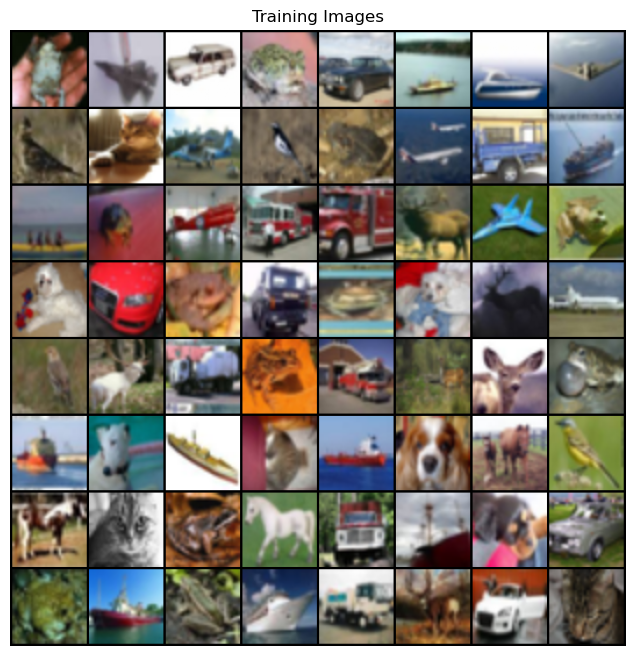

In [6]:
train_dataloader = idist.auto_dataloader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS
)

test_dataloader = idist.auto_dataloader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS
)


real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### Defining the Generator Class and Model Architecture

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=n_z, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    # Forward Loop of the Generator
    def forward(self, input):
        return self.model(input)

In [8]:
# Instantiating Generator
G = idist.auto_model(Generator())
G.to(device)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

### Defining the Discriminator Class and Model Architecture

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(in_channels=256, out_channels=1, kernel_size=4, stride=1, padding=0),
        )

    def forward(self, input):
        rtn = self.model(input)
        return torch.flatten(rtn)

In [10]:
# Instantiating Discriminator
D = idist.auto_model(Discriminator())
D.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [11]:
# Initializing Optimizers to Use

optim_D = idist.auto_optim((torch.optim.Adam(D.parameters(), lr=lr[1], betas=(b1, b2))))
optim_G = idist.auto_optim((torch.optim.Adam(G.parameters(), lr=lr[1], betas=(b1, b2))))

### Training Loop

In [12]:
###################################################################
# Gradient Penalty Calculation for the Wasserstein Loss Calculation
###################################################################

def calculate_gradient_penalty(model, real_images, fake_images, device):
    # Random weight term for interpolation between real and fake data
    alpha = torch.randn((real_images.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty

In [13]:
##############################################
# Start of Training Loop
##############################################
fixed_noise = torch.randn(BATCH_SIZE, n_z, 1, 1, device=device)

def training_step(engine, data):
    img_list = []
    D.train()
    G.train()
    
    for i in range(n_critic):
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, n_z, 1, 1, device=device)

        ##############################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ##############################################
        # Set discriminator gradients to zero.
        D.zero_grad()

        # Train with real
        real_output = D(real_images)
        errD_real = torch.mean(real_output)
        D_x = real_output.mean().item()

        # Generate fake image batch with G
        fake_images = G(noise)

        # Train with fake
        fake_output = D(fake_images.detach())
        errD_fake = torch.mean(fake_output)
        D_G_z1 = fake_output.mean().item()
        
        # Calculate W-div gradient penalty
        gradient_penalty = calculate_gradient_penalty(model=D, real_images=real_images.data, fake_images=fake_images.data, device=device)
        # print("  ↳ gradient_penalty =", gradient_penalty.item())

        # Add the gradients from the all-real and all-fake batches
        errD = -errD_real + errD_fake + gradient_penalty * 10
        errD.backward()
        # Update D
        optim_D.step()

    # Train the generator every n_critic iterations
    ##############################################
    # (2) Update G network: maximize log(D(G(z)))
    ##############################################
    # Set generator gradients to zero
    G.zero_grad()

    # Generate fake image batch with G
    fake_images = G(noise)
    fake_output = D(fake_images)
    errG = -torch.mean(fake_output)
    D_G_z2 = fake_output.mean().item()
    errG.backward()
    optim_G.step()

    # progress_bar.set_description(f"[{epoch + 1}/{epochs}][{i + 1}/{len(dataloader)}] "
    #                                 f"Loss_D: {errD.item():.6f} Loss_G: {errG.item():.6f} "
    #                                 f"D(x): {D_x:.6f} D(G(z)): {D_G_z1:.6f}/{D_G_z2:.6f}")
    
    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": D_x,
        "D_G_z1": D_G_z1,
        "D_G_z2": D_G_z2,
    }

        # iters = i + epoch * len(dataloader) + 1

        # # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 250 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
        #     with torch.no_grad():
        #         fake = G(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        # if iters == int(n_iters):  # If the iteration is reached, exit.
        #     break

In [14]:
trainer = Engine(training_step)

In [15]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(model.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        if hasattr(model, 'bias') and model.bias is not None:
            nn.init.constant_(model.bias, 0.0)
            
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(model.weight, 1.0)
        nn.init.constant_(model.bias, 0.0)

In [16]:
@trainer.on(Events.STARTED)
def init_weights():
    D.apply(initialize_weights)
    G.apply(initialize_weights)

In [17]:
G_losses = []
D_losses = []

@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    out = engine.state.output
    G_losses.append(out['Loss_G'])
    D_losses.append(out['Loss_D'])


In [18]:
img_list = []

@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        generated = G(fixed_noise).cpu()
    img_list.append(generated)

### Defining the Fréchet Inception Distance and Inception Score Metrics

In [19]:
from ignite.metrics import FID, InceptionScore

# Fréchet Inception Distance
fid = FID(device=device)

# Inception Score
IS = InceptionScore(device=device, output_transform=lambda x: x[0])

### Resizing Images for InceptionV3 model (used by FID and IS metrics)

In [20]:
import PIL.Image as Image

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

In [21]:
def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(BATCH_SIZE, n_z, 1, 1, device=device)
        G.eval()
        fake = G(noise)
        fake = interpolate(fake)
        real = interpolate(batch[0])
        
        return fake, real

### Defining the Evaluator Engine

In [22]:
evaluator = Engine(evaluation_step)
fid.attach(evaluator, "FID")
IS.attach(evaluator, "IS")

### Creating Function to Log Training Results

In [23]:
fid_values = []
is_values = []

@trainer.on(Events.EPOCH_COMPLETED)
def training_results(engine):
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")

In [24]:
from ignite.metrics import RunningAverage

RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [25]:
from ignite.contrib.handlers import ProgressBar

ProgressBar().attach(trainer, metric_names=['Loss_G', 'Loss_D'])
ProgressBar().attach(evaluator)

/home/athimmaudayakumar/.local/lib/python3.11/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [26]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=5)
    evaluator.run(test_dataloader, max_epochs=1)
    eval_metrics = evaluator.state.metrics
    fid_score = eval_metrics["FID"]
    is_score = eval_metrics["IS"]
    print(f"FID Score: {fid_score}")
    print(f"IS Score: {is_score}")

In [27]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

2025-06-04 04:58:56,958 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2025-06-04 04:58:56,959 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7efff8b29ee0>' in 1 processes


[1/55]   2%|1          [00:00<?]

Epoch [1/5] Metric Scores


[1/55]   2%|1          [00:00<?]

Epoch [2/5] Metric Scores


[1/55]   2%|1          [00:00<?]

Epoch [3/5] Metric Scores


[1/55]   2%|1          [00:00<?]

Epoch [4/5] Metric Scores


[1/55]   2%|1          [00:00<?]

Epoch [5/5] Metric Scores


[1/24]   4%|4          [00:00<?]

Current run is terminating due to exception: 
    Number of Training Features and Testing Features should be equal (torch.Size([128, 1000]) != torch.Size([56, 1000]))
                
Engine run is terminating due to exception: 
    Number of Training Features and Testing Features should be equal (torch.Size([128, 1000]) != torch.Size([56, 1000]))
                
2025-06-04 05:14:55,503 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


ValueError: 
    Number of Training Features and Testing Features should be equal (torch.Size([128, 1000]) != torch.Size([56, 1000]))
                

### Results

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

In [ ]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()

In [ ]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))